In [1]:
library (tidyverse)
library (tidymodels) 
library(repr)
library(tidyclust)
library(GGally)
library (themis)
options(repr.matrix.max.rows = 7)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

# Predicting User Subscription to a Game-related Newsletter based on Age and Total Play Time of Users - A Study on a Minecraft Server 

## Introduction

#### Background:
This project is based on data collected by The Pacific Laboratory for Artificial Intelligence (PLAI) at the University of British Columbia, which monitored user data to investigate and predict various user behaviours, such as identifying characteristics that are most predictive of subscribing to a game-related newsletter. This investigation was conducted on former DSCI 100 students at UBC, who were compensated with a bonus grade in the class for voluntarily participating in the research.

#### Question:
**Can user age and total playing time predict whether the user subscribed to a game-related newsletter in the players.csv dataset?**

#### Data Description:
The players.csv dataset contains user information about 196 students who participated in the research, with 7 pieces of information provided as columns for each user. With just the read_csv function, the categorical variables, experience, and gender, were initially detected as characters. Thus, they were manually corrected as factor variables. 

##### Issues with data:
- Specifically regarding the question of interest, the response variable, “subscribe”, has to be a categorical value. Thus, the data is wrangled so that it is made categorical.
- 2 rows contain “Age” as NA. These rows were excluded for the data analysis for the classification algorithm to work properly. 

Details regarding the variables are listed below. 

1. **experience (fct)** → User’s competency rating in Minecraft; one of “Amateur”, “Beginner”, “Pro”, “Regular”, or “Veteran”. 
2. **subscribe (lgl)** → Whether the user subscribed to a game-related newsletter; either TRUE or FALSE.
3. **hashedEmail (chr)** → Hashed emails of users to identify unique users 
4. **played_hours (dbl)** → Total hours of playing time on the Minecraft server
5. **name (chr)** → User nickname on the server 
6. **gender (fct)** → Gender of the user. Either “Male”, “Female”, “Non-binary”, “Prefer not to say”, “Agender”, “Two-Spirited”, or “Other”. 
7. **Age (dbl)** → Age of the user. Ranges between 8 and 50. 


In [2]:
# Load the raw data + Correct variable types

players_raw <- read_csv ( "players.csv" ) |>
    mutate (experience = as_factor (experience) , gender = as_factor (gender) )
players_raw

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience subscribe
1   Pro         TRUE    
2   Veteran     TRUE    
3   Veteran    FALSE    
4   Amateur     TRUE    
⋮   ⋮          ⋮        
194 Amateur    FALSE    
195 Amateur    FALSE    
196 Pro         TRUE    
    hashedEmail                                                     
1   f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d
2   f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9
3   b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28
4   23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5
⋮   ⋮                                                               
194 d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb
195 f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436
196 d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11
    played_hours name      gender            Age
1   30.3         Morgan    Male               9 
2    3.8         Christian Male              17 
3    0.0         Blake     Male              17 
4    0.7         Flora     Female            21 
⋮   ⋮            ⋮         ⋮                 ⋮  
194 0.0          Dylan     Prefer not to say 17 
195 2.3          Harlow    Male              17 
196 0.2          Ahmed     Other             NA

## Methods & Results:

- Overall, this analysis used the K-nearest neighbours (KNN) algorithm to predict the “subscribe” variable based on "Age" and "played_hours" variables as predictors.

1. First, the raw data was reduced to only relevant variables, and the response variable’s type was corrected to be suitable for the classification algorithm. Also, 2 rows containing NA for Age were removed. 
2. Next, the total numbers of subscribed and unsubscribed users were identified to determine that upscaling would be required to account for the class imbalance in “subscribe”. 
3. Then, the whole data was split into 70% training and 30% testing data sets for a KNN classification algorithm. 
4. The recipe and model were created to build the KNN model. The preprocessing step standardized the predictors and upsampled the response variable. 
5. Then, the best k value was selected by running a 5-fold cross-validation process with k values between 1 and 10. 
6. The final model was constructed based on the best k value identified in step 5. 
7. A fitted model is built using the training set, and accuracy metrics were recorded on the training set and the testing set separately. 
8. Finally, the classifier is visualized as colored regions to visually analyze the classification model. 


In [3]:
# Tidy the data + Reduce the data to only relevant variables for the analysis

players_data <- read_csv ( "players.csv" ) |> 
    drop_na() |> # drop 2 rows where Age = NA 
    mutate ( subscribe = as_factor (subscribe) ) |> 
    select ( subscribe , Age, played_hours )
players_data

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


subscribe Age played_hours
1   TRUE       9  30.3        
2   TRUE      17   3.8        
3   FALSE     17   0.0        
4   TRUE      21   0.7        
⋮   ⋮         ⋮   ⋮           
192 FALSE     22  0.3         
193 FALSE     17  0.0         
194 FALSE     17  2.3

In [4]:
# Identification of Class Imbalance in "subscribe"
subscription_prop <- players_data |> 
    group_by (subscribe) |> 
    summarise (count = n() ) 
subscription_prop


subscribe count
1 FALSE      52  
2 TRUE      142

In [5]:
set.seed (1217) 

players_split <- initial_split (data = players_data , prop = 0.7 , strata = subscribe) 
players_training <- training ( players_split ) 
players_testing <- testing ( players_split) 


players_recipe <- recipe ( subscribe ~ Age + played_hours , data = players_training ) |> 
    step_scale ( all_predictors() ) |> 
    step_upsample( subscribe, over_ratio = 1) |>
    step_center (all_predictors() ) 

k_vals <- tibble ( neighbors = 1:10 ) 

knn_spec <- nearest_neighbor(weight_func = "rectangular" ,  neighbors = tune () ) |> 
    set_engine ( "kknn" ) |> 
    set_mode ("classification" ) 

best_k <- workflow () |> 
    add_model ( knn_spec ) |> 
    add_recipe (players_recipe ) |> 
    tune_grid (resamples = vfold_cv( data = players_training , v = 5 , strata = subscribe), grid = k_vals) |> 
    collect_metrics () |> 
    filter ( .metric == "accuracy" ) |> 
    slice_max (mean) |> 
    pull (neighbors) 

best_k

knn_spec_final <- nearest_neighbor (weight_func = "rectangular" ,  neighbors = best_k ) |> 
    set_engine ( "kknn" ) |> 
    set_mode ("classification" ) 

players_fit <- workflow () |> 
    add_model ( knn_spec_final ) |> 
    add_recipe (players_recipe ) |> 
    fit ( players_training )

# Accuracy on the training set 
result_training <- predict (players_fit , players_training)|>
    bind_cols (players_training) 

accuracy_training <- metrics (data = result_training, truth = subscribe , estimate = .pred_class) |>
    filter (.metric == "accuracy" ) |> 
    pull (.estimate)

accuracy_training 

# Accuracy on the testing set 
result_testing <- predict (players_fit , players_testing)|>
    bind_cols (players_testing) 

accuracy_testing <- metrics (data = result_testing, truth = subscribe , estimate = .pred_class) |>
    filter (.metric == "accuracy" ) |> 
    pull (.estimate)

accuracy_testing 




[1] 1

[1] 0.6666667

[1] 0.5423729

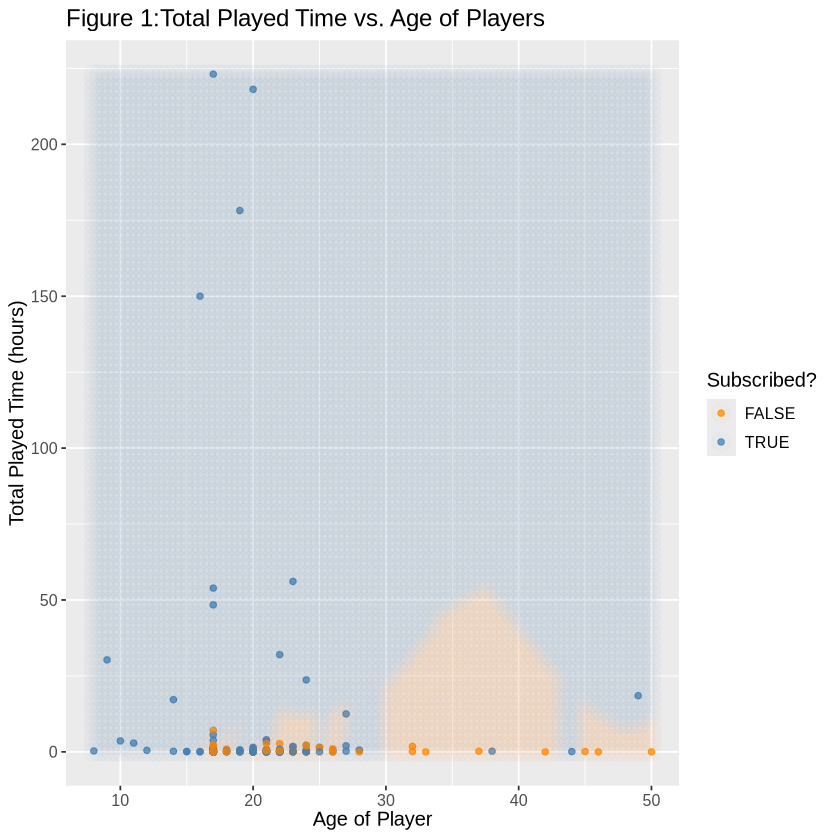

In [6]:
#Plotting the Classification Model 


# create the grid of area/smoothness vals, and arrange in a data frame
Age_grid <- seq(min(players_data$Age),
                max(players_data$Age),
                length.out = 100)
ph_grid <- seq(min(players_data$played_hours),
                max(players_data$played_hours),
                length.out = 100)
asgrid <- as_tibble(expand.grid(Age = Age_grid,
                                played_hours = ph_grid))

# use the fit workflow to make predictions at the grid points
knnPredGrid <- predict( players_fit , asgrid )

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid) 

# plot:
# 1. the colored scatter of the original data
# 2. the faded colored scatter for the grid points
players_plot <- ggplot ( players_data , aes ( x = Age , y = played_hours, color = subscribe ) ) + 
    geom_point ( alpha = 0.75 ) +
    geom_point(data = prediction_table,
             mapping = aes(x = Age,
                           y = played_hours,
                           color = .pred_class),
             alpha = 0.02,
             size = 5) +
    labs ( title = "Figure 1:Total Played Time vs. Age of Players" , 
          x = "Age of Player" , y = "Total Played Time (hours)" , color = "Subscribed?" ) +
  scale_color_manual(values = c("darkorange", "steelblue")) +
  theme(text = element_text(size = 12))

players_plot

## Insights

- From this plot, it is evident that most students across various ages played minimally, less than 10 hours total. This is probably because most students were not incentivized enough to play their minimum required time to obtain their bonus grade. Also, even with upsampling, the majority of the plot is dominated by TRUE predictions, and the boundaries of classification regions seem irregular and random

### Why is this method appropriate? 
The k-nearest-neighbour algorithm is appropriate for this analysis because this model is flexible on the shape of the plot, which seems quite random and irregular. 

### Assumptions 
In order for this method to be meaningful, the feature scales must be comparable. Specifically, since the K-NN algorithm uses Euclidean distances, it is important to standardize the predictors in the recipe step. 

### Limitations
This model is limited in that it is only applicable within the ranges of the training dataset, because the K-NN algorithm performs poorly beyond the scope of the training set. 
### Comparing & Selecting the model
I optimized the model by tuning the number of neighbours (k value) within the range of 1-10. I compared the average accuracy metrics from 5-fold cross-validation for each k value, and selected the model with the highest accuracy metrics. 


## Discussion

### Summary 
The above plot (Figure 1) shows that even with upsampling the response variable, the plot is dominated by the TRUE predictions, showing that the classifier predicts TRUE more than FALSE much more frequently. This observation may explain the low accuracy metrics at 67% and 54%, on the training set and the testing set, respectively. 

Also, the irregular patterns in the regions of predictions, alongside the low accuracy metrics, show that age and total playing time are not good enough to reliably or at least reasonably predict user subscription. 

This lack of significant correlation probably resulted from the fact that most students had very low playing times, rendering the played_hours variable practically irrelevant in reasonably predicting subscription based on this variable. 

### Expectation vs. Result
I initially thought that these two predictor variables, age and played_hours, could be valuable in reasonably predicting user subscription, but I overlooked the fact that the played_hours variable is practically became irrelevant due to the fact that too many students played minimal hours. 

### Potential Impacts of the Finding
This finding reveals more about the inherent nature of the dataset itself than the model; perhaps, this model is proof that students were too weakly incentivized to participate in the study for substantial hours, because most of the data contains minimal playing hours. Thus, this model might inform the research team to perhaps increase the incentives in participating in the study to observe a wider range and overall higher values in the played_hours variable. 

### Future Questions 
This analysis might pose questions regarding different incentives that might motivate participants to play longer hours, such as: “What kinds of incentives are the most effective at motivating students to contribute to the server for longer hours?”
